In [1]:
%pylab inline

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'gaussian-pulse', '1')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 16}
matplotlib.rc('font', **font)

import numpy as np
from scipy import constants
import scipy as sp
from scipy.special import hankel2
from matplotlib import pyplot as plt
from Electromagnetics.PWE import *


Populating the interactive namespace from numpy and matplotlib


### Gaussian beam

(256, 256) (256, 256) (256, 256)


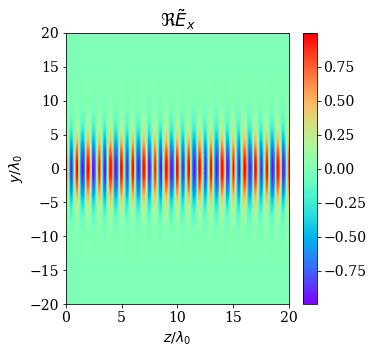

In [6]:

f = 10.0*constants.giga
L0 = None
if f==0:
    L0 = constants.c/1.0
else:
    L0 = constants.c/f

Ny = 2**8
Nz = 2**8
a = 20
b = 20
y = np.linspace(-a*L0, a*L0, Ny)
z = np.linspace(0, b*L0, Nz)


W = 5*L0 ##waist
Ex = np.exp(-(y/W)**2)
Ey = np.zeros(Ny)


pwe = PWE2D(f, y, Ex, Ey)
pwe.GetK()

#z = np.linspace(4.0*L0, 6.0*L0, Nz)
Z, Y, E_zy, H_zy = pwe.GetFields(z)

print(Z.shape, Y.shape, E_zy[0].shape)

figsize(5*b/a, 5)
pcolormesh(Z/L0, Y/L0, np.real(E_zy[0]), cmap='rainbow')
title(r'$\Re\tilde{E}_{x}$', fontsize=18)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")
savefig(os.path.join(dir_name, 'gaussian-beam'+file_ext), bbox_inches='tight', pad_inches=0.5)
colorbar() 



### Gaussian pulse

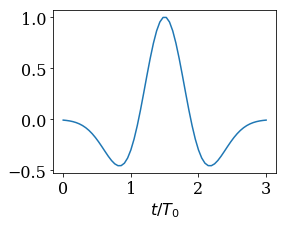

w_max :  3695991357.16


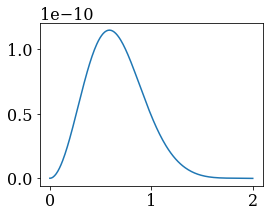

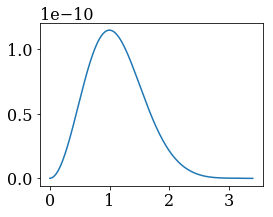

z_y_ratio :  1.0


/home/nima/ipython workspace/Electromagnetics/PWE.py:104: RuntimeWarning: invalid value encountered in true_divide
  _Ez = -ky*_Ey/kz
/home/nima/ipython workspace/Electromagnetics/PWE.py:108: RuntimeWarning: invalid value encountered in true_divide
  self.Hx_f = (ky*self.Ez_f - kz*self.Ey_f)/(self.w*self.mu)
/home/nima/ipython workspace/Electromagnetics/PWE.py:109: RuntimeWarning: divide by zero encountered in true_divide
  self.Hy_f = (kz*self.Ex_f - kx*self.Ez_f)/(self.w*self.mu)
/home/nima/ipython workspace/Electromagnetics/PWE.py:109: RuntimeWarning: invalid value encountered in true_divide
  self.Hy_f = (kz*self.Ex_f - kx*self.Ez_f)/(self.w*self.mu)
/home/nima/ipython workspace/Electromagnetics/PWE.py:110: RuntimeWarning: divide by zero encountered in true_divide
  self.Hz_f = (kx*self.Ey_f - ky*self.Ex_f)/(self.w*self.mu)
/home/nima/ipython workspace/Electromagnetics/PWE.py:110: RuntimeWarning: invalid value encountered in true_divide
  self.Hz_f = (kx*self.Ey_f - ky*self.Ex_f)/(

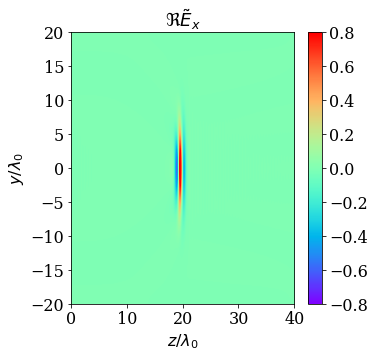

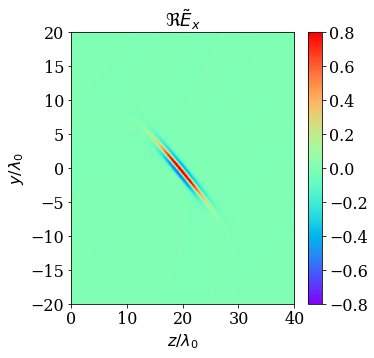

In [28]:
file_ext = '.eps'
prefix = 'diff'       ##'tr', 'diff'
figsize(5, 5)

f_c = 1.0*constants.giga
_f_c = None
L0 = None
if f_c==0:
    _f_c = 1.0
    L0 = constants.c/_f_c
    T0 = 1.0/_f_c    
else:
    L0 = constants.c/f_c
    T0 = 1.0/f_c

Ny = 2**10
Nz = 2**10
a = 20
b = 40
y = np.linspace(-a*L0, a*L0, Ny)
z = np.linspace(0, b*L0, Nz)


## turn the source on and off smoothely from t_0 to t_1
W_t = 0.5*T0
t_0 = 0.0
t_1 = 6.0*W_t
t_c = (t_0+t_1)/2
N_t = 2**6
t = np.linspace(t_0, t_1, N_t)
dt = t[1]-t[0]

pulse_type = "diff"
time_reverse = False
just_negate_insteadof_tr = True
theta_zy = -45.0/180.0*np.pi

A_t = None
if pulse_type=="asymm":
    A_t = np.exp(-(t - t_c + T0/4)**2/W_t**2) - np.exp(-(t - t_c - T0/4)**2/W_t**2)
elif pulse_type=="diff":
    A_t = (t - t_c + T0/4)*np.exp(-(t - t_c + T0/4)**2/W_t**2) - \
        (t - t_c - T0/4)*np.exp(-(t - t_c - T0/4)**2/W_t**2)
        
A_t /= np.max(np.abs(A_t))
figsize(4,3)
plot(t/T0, A_t)
xlabel(r'$t/T_0$')
show()

## frequency spectrum
## the frequency range should be set manually
## it should have only positive frequencies, and this range should be sampled well

f_0 = 0
f_1 = 1.0/W_t

N_f = 2**8
f = np.linspace(f_0, f_1, N_f)
df = f[1] - f[0]
A_f = np.zeros(N_f, dtype=complex)
for i_f in range(N_f):
    w_i = 2.0*np.pi*f[i_f]
    A_f[i_f] = A_t.dot(np.exp(+1j*w_i*t))
A_f *= dt/(2.0*np.pi)

w_max = 2.0*np.pi*f[np.argmax(np.abs(A_f))]
print('w_max : ', w_max)

if f_c!=0.0:
    plot(f/f_c, np.abs(A_f))
else:
    plot(f, np.abs(A_f))
show()

plot(2.0*np.pi*f/w_max, np.abs(A_f))
show()

## get the Gaussian pulse
z_y_ratio = b/(2*a)
print('z_y_ratio : ', z_y_ratio)
figsize(5*z_y_ratio, 5)
W = 5*L0 ##waist
Ex = np.exp(-(y/W)**2)
Ey = np.zeros(Ny)

Ex_zy_tot = None
Hz_zy_tot = None
Hy_zy_tot = None
Z, Y = None, None

t_snap = 21.0*T0

for i_f in range(N_f):

    pwe = PWE2D(f[i_f], y, Ex, Ey)
    pwe.GetK()

    #z = np.linspace(4.0*L0, 6.0*L0, Nz)
    Z, Y, E_zy, H_zy = pwe.GetFields(z)
    w_i = 2.0*np.pi*f[i_f]
    if w_i!=0:
        if Ex_zy_tot is None:
            Ex_zy_tot = A_f[i_f]*E_zy[0]*exp(-1j*w_i*t_snap)
            Hz_zy_tot = A_f[i_f]*H_zy[2]*exp(-1j*w_i*t_snap)
            Hy_zy_tot = A_f[i_f]*H_zy[1]*exp(-1j*w_i*t_snap)
        else:
            Ex_zy_tot += A_f[i_f]*E_zy[0]*exp(-1j*w_i*t_snap)
            Hz_zy_tot += A_f[i_f]*H_zy[2]*exp(-1j*w_i*t_snap)
            Hy_zy_tot += A_f[i_f]*H_zy[1]*exp(-1j*w_i*t_snap)

Ex_zy_tot *= df
Hy_zy_tot *= df
Hz_zy_tot *= df
Ht_zy_tot = Hy_zy_tot

Ex_tot_max = np.max(np.abs(Ex_zy_tot))
Ex_zy_tot /= Ex_tot_max
Hy_zy_tot /= Ex_tot_max
Hz_zy_tot /= Ex_tot_max

Ht_zy_tot = Hy_zy_tot

imshow(np.real(Ex_zy_tot).T, vmin=-0.8, vmax=0.8,\
      cmap='rainbow', interpolation=None,\
      origin='lower', \
      extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
      aspect='auto')
#pcolormesh(Z/L0, Y/L0, np.real(Ex_zy_tot), cmap='rainbow')
title(r'$\Re\tilde{E}_{x}$', fontsize=18)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")

file_name = os.path.join(dir_name, '{}_gaussian-pulse'.format(prefix)+file_ext)
    
colorbar() 
savefig(file_name, bbox_inches='tight', pad_inches=0.5)
show()

Ex_zy_tot_diag = np.zeros(Ex_zy_tot.shape, dtype=complex)
Ht_zy_tot_diag = np.zeros(Ht_zy_tot.shape, dtype=complex)
interp_rotation = True

if not interp_rotation:
    if (not chirped):
        if deriv_order==2:
            for i_z in range(Nz):
                for i_y in range(Nz):
                    if 0<=-Nz//2+i_z+i_y<Nz: 
                        Ex_zy_tot_diag[i_z, i_y] = Ex_zy_tot[(-Nz//2+i_z+i_y), i_y]
                        Ht_zy_tot_diag[i_z, i_y] = Ht_zy_tot[(-Nz//2+i_z+i_y), i_y]
        else:
            for i_z in range(Nz):
                for i_y in range(Nz):
                    if 0<=Nz//2+i_z-i_y<Nz: 
                        Ex_zy_tot_diag[i_z, i_y] = Ex_zy_tot[(Nz//2+i_z-i_y), i_y]
                        Ht_zy_tot_diag[i_z, i_y] = Ht_zy_tot[(Nz//2+i_z-i_y), i_y]
    else:
        for i_z in range(Nz):
            for i_y in range(Nz):
                if 0<=Nz//2+i_z-i_y<Nz: 
                    Ex_zy_tot_diag[i_z, i_y] = Ex_zy_tot[Nz-1-(Nz//2+i_z-i_y), i_y]
                    Ht_zy_tot_diag[i_z, i_y] = Ht_zy_tot[Nz-1-(Nz//2+i_z-i_y), i_y]
else:
    from scipy.interpolate import interp2d, RectBivariateSpline
    Ex_r_interp = RectBivariateSpline(z, y, np.real(Ex_zy_tot))
    Ex_i_interp = RectBivariateSpline(z, y, np.imag(Ex_zy_tot))
    Hy_r_interp = RectBivariateSpline(z, y, np.real(Hy_zy_tot))
    Hy_i_interp = RectBivariateSpline(z, y, np.imag(Hy_zy_tot))
    Hz_r_interp = RectBivariateSpline(z, y, np.real(Hz_zy_tot))
    Hz_i_interp = RectBivariateSpline(z, y, np.imag(Hz_zy_tot))
    if time_reverse:
        Ex_zy_tot_tr = np.zeros((Nz,Ny), dtype=complex)
        Hy_zy_tot_tr = np.zeros((Nz,Ny), dtype=complex)
        Hz_zy_tot_tr = np.zeros((Nz,Ny), dtype=complex)
        for i_z in range(Nz):
            for i_y in range(Ny):
                if just_negate_insteadof_tr:
                    Ex_zy_tot_tr[i_z,i_y] = -Ex_zy_tot[i_z, i_y]
                    Hy_zy_tot_tr[i_z,i_y] = -Hy_zy_tot[i_z, i_y]
                    Hz_zy_tot_tr[i_z,i_y] = -Hz_zy_tot[i_z, i_y]
                else:
                    Ex_zy_tot_tr[i_z,i_y] = Ex_zy_tot[Nz-1-i_z, Ny-1-i_y]
                    Hy_zy_tot_tr[i_z,i_y] = Hy_zy_tot[Nz-1-i_z, Ny-1-i_y]
                    Hz_zy_tot_tr[i_z,i_y] = Hz_zy_tot[Nz-1-i_z, Ny-1-i_y]
                    
        Ex_r_interp = RectBivariateSpline(z, y, np.real(Ex_zy_tot_tr))
        Ex_i_interp = RectBivariateSpline(z, y, np.imag(Ex_zy_tot_tr))
        Hy_r_interp = RectBivariateSpline(z, y, np.real(Hy_zy_tot_tr))
        Hy_i_interp = RectBivariateSpline(z, y, np.imag(Hy_zy_tot_tr))
        Hz_r_interp = RectBivariateSpline(z, y, np.real(Hz_zy_tot_tr))
        Hz_i_interp = RectBivariateSpline(z, y, np.imag(Hz_zy_tot_tr))
        
    for i_z in range(Nz):
        for i_y in range(Nz):
            z_i = (z[i_z]-z[Nz//2])*np.cos(theta_zy) - (y[i_y]-y[Ny//2])*np.sin(theta_zy) + z[Nz//2]
            y_i = (z[i_z]-z[Nz//2])*np.sin(theta_zy) + (y[i_y]-y[Ny//2])*np.cos(theta_zy) + y[Ny//2]
            if y[0]<y_i<y[-1] and z[0]<z_i<z[-1]:
                Ex_zy_tot_diag[i_z,i_y] = Ex_r_interp(z_i, y_i) + 1j*Ex_i_interp(z_i, y_i)
                Hy_i = Hy_r_interp(z_i, y_i) + 1j*Hy_i_interp(z_i, y_i)
                Hz_i = Hz_r_interp(z_i, y_i) + 1j*Hz_i_interp(z_i, y_i)
                Ht_zy_tot_diag[i_z,i_y] = Hy_i*np.cos(theta_zy) - Hz_i*np.sin(theta_zy)
        
    
imshow( np.real(Ex_zy_tot_diag).T, vmin=-0.8, vmax=0.8,\
      cmap='rainbow', interpolation=None,\
      origin='lower', \
      extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
      aspect='auto')
#pcolormesh(Z/L0, Y/L0, np.real(Ex_zy_tot_diag), cmap='rainbow')
title(r'$\Re\tilde{E}_{x}$', fontsize=18)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")

colorbar() 
show()

np.savez(os.path.join(dir_name, '{}_data_EH'.format(prefix)), f_c=f_c, L0=L0, y=y, z=z, Z=Z, Y=Y, \
        w_max=w_max, theta_zy=theta_zy, Ex_zy_tot=Ex_zy_tot, Ht_zy_tot=Ht_zy_tot,\
        Ex_zy_tot_diag=Ex_zy_tot_diag, Ht_zy_tot_diag=Ht_zy_tot_diag)



### saved results

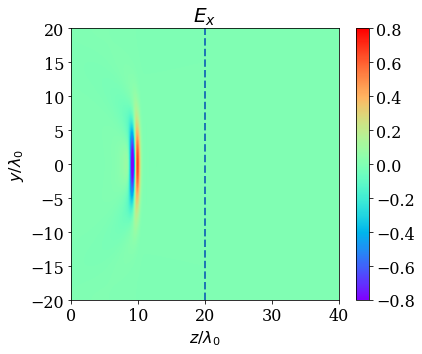

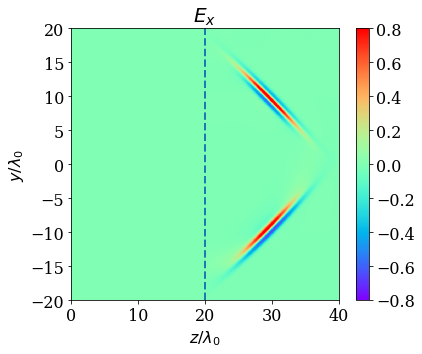

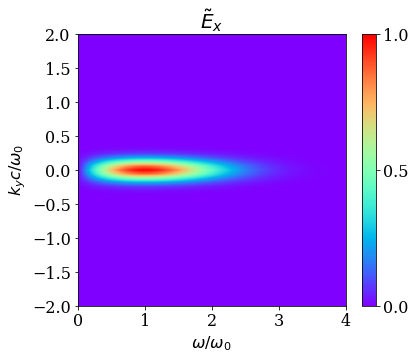

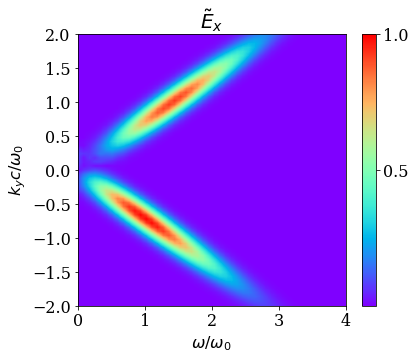

In [31]:
from scipy.interpolate import interp2d

prefix = 'diff'      ## 'tr', 'diff': will be added to created files
prefix_i = 'tr'      ## the files with this prefix will be read as incident
prefix_t0 = 'tr'     ## the files with this prefix will be read as transmitted
prefix_t1 = 'diff'
file_ext = '.eps'
figsize(5, 5)

file_EH = np.load(os.path.join(dir_name, '{}_data_EH.npz'.format(prefix_i)))
f_c = file_EH['f_c'] 
z=file_EH['z'] 
y=file_EH['y'] 
L0=file_EH['L0'] 
Z=file_EH['Z'] 
Y=file_EH['Y'] 
w_max=file_EH['w_max']
Ex_zy_tot = file_EH['Ex_zy_tot']
Ht_zy_tot = file_EH['Ht_zy_tot']
Nz = len(z)
Ny = len(y)

file_EH = np.load(os.path.join(dir_name, '{}_data_EH.npz'.format(prefix_t0)))
Ex_zy_tot_diag = file_EH['Ex_zy_tot_diag']
Ht_zy_tot_diag = file_EH['Ht_zy_tot_diag']
theta_zy = file_EH['theta_zy']

Ex_zy_tot_diag_1, Ht_zy_tot_diag_1, theta_zy_1 = [None]*3
if prefix_t1 is not None:
    file_EH = np.load(os.path.join(dir_name, '{}_data_EH.npz'.format(prefix_t1)))
    Ex_zy_tot_diag_1 = file_EH['Ex_zy_tot_diag']
    Ht_zy_tot_diag_1 = file_EH['Ht_zy_tot_diag']
    theta_zy_1 = file_EH['theta_zy']


##-------------------------------

from scipy.interpolate import interp2d, RectBivariateSpline
Ex_r_interp = RectBivariateSpline(z, y, np.real(Ex_zy_tot))
Ex_diag_r_interp = RectBivariateSpline(z, y, np.real(Ex_zy_tot_diag))
Ex_diag_r_interp_1 = None
if prefix_t1 is not None:
    Ex_diag_r_interp_1 = RectBivariateSpline(z, y, np.real(Ex_zy_tot_diag_1))

Ex_comb = np.zeros((Nz,Ny))
for i_z in range(Nz):
    for i_y in range(Ny):
        if i_z<=Nz//2:
            z_i = z[i_z]+z[0]+(z[-1]-z[0])/4
            y_i = y[i_y]#+y[0]+(y[-1]-y[0])/4
            if z[0]<=z_i<=z[-1] and y[0]<=y_i<=y[-1]:
                Ex_comb[i_z,i_y] = Ex_r_interp(z_i, y_i)
            

figsize(6,5)
imshow( np.real(Ex_comb).T, vmin=-0.8, vmax=0.8,\
      cmap='rainbow', interpolation=None,\
      origin='lower', \
      extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
      aspect='auto')
title(r'$E_{x}$', fontsize=20)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")
axvline(x=z[Nz//2]/L0, linewidth=2, linestyle='--')
colorbar()

file_name = os.path.join(dir_name, '{}_E-before'.format(prefix)+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()

Ex_comb = np.zeros((Nz,Ny))
for i_z in range(Nz):
    for i_y in range(Ny):
        if Nz//2<=i_z<Nz:
            z_i = z[i_z]+z[0]+(z[-1]-z[0])/4-z[Nz//2]
            y_i = y[i_y]-y[0]-(y[-1]-y[0])/4
            if theta_zy<0:
                y_i = y[i_y]-y[0]-(y[-1]-y[0])*3/4
            if z[0]<=z_i<=z[-1] and y[0]<=y_i<=y[-1]:
                Ex_comb[i_z,i_y] = Ex_diag_r_interp(z_i, y_i)
if prefix_t1 is not None:
    for i_z in range(Nz):
        for i_y in range(Ny):
            if Nz//2<=i_z<Nz:
                z_i = z[i_z]+z[0]+(z[-1]-z[0])/4-z[Nz//2]
                y_i = y[i_y]-y[0]-(y[-1]-y[0])/4
                if theta_zy_1<0:
                    y_i = y[i_y]-y[0]-(y[-1]-y[0])*3/4
                if z[0]<=z_i<=z[-1] and y[0]<=y_i<=y[-1]:
                    Ex_comb[i_z,i_y] += Ex_diag_r_interp_1(z_i, y_i)


figsize(6,5)
imshow( np.real(Ex_comb).T, vmin=-0.8, vmax=0.8,\
      cmap='rainbow', interpolation=None,\
      origin='lower', \
      extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
      aspect='auto')
title(r'$E_{x}$', fontsize=20)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")
axvline(x=z[Nz//2]/L0, linewidth=2, linestyle='--')
colorbar()
file_name = os.path.join(dir_name, '{}_E-after'.format(prefix)+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()


##-------------------------------

if prefix_t1 is not None:
    Ex_zy_tot_diag += Ex_zy_tot_diag_1
    Ht_zy_tot_diag += Ht_zy_tot_diag_1

log_plot = False
interp_plot = False
use_imshow = True

Ex_zy_tot_fft = np.fft.fftshift(np.fft.fft2(np.real(Ex_zy_tot)))
k_y_arr = 2.0*np.pi*FourierReciprocalSpace(y)
w_t_arr = 2.0*np.pi*FourierReciprocalSpace(z/constants.c)
W_t_arr, K_y_arr = np.meshgrid(w_t_arr, k_y_arr, indexing='ij')
dA = (k_y_arr[1]-k_y_arr[0])*(w_t_arr[1]-w_t_arr[0])/constants.c


if not log_plot:
    if use_imshow:
        if f_c!=0:
            imshow( np.abs(Ex_zy_tot_fft).T/np.max(np.abs(Ex_zy_tot_fft)), \
                  cmap='rainbow', interpolation='bilinear',\
                  origin='lower', \
                  extent=[w_t_arr[0]/w_max, w_t_arr[-1]/w_max, k_y_arr[0]*constants.c/w_max, k_y_arr[-1]*constants.c/w_max],\
                  aspect='auto')
        else:
            imshow( np.abs(Ex_zy_tot_fft).T/np.max(np.abs(Ex_zy_tot_fft)), \
                  cmap='rainbow', interpolation='bilinear',\
                  origin='lower', \
                  extent=[w_t_arr[0], w_t_arr[-1], k_y_arr[0]*constants.c, k_y_arr[-1]*constants.c],\
                  aspect='auto')
    else:
        if not interp_plot:
            pcolormesh(W_t_arr/w_max, K_y_arr*constants.c/w_max, \
                       np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft)), \
                       cmap='rainbow')
        else:
            r_interp = interp2d(W_t_arr, K_y_arr, np.real(Ex_zy_tot_fft), kind='linear') 
            i_interp = interp2d(W_t_arr, K_y_arr, np.imag(Ex_zy_tot_fft), kind='linear')

            w_t_arr_2 = np.linspace(w_t_arr[0], w_t_arr[-1], 2**9)
            k_y_arr_2 = np.linspace(k_y_arr[0], k_y_arr[-1], 2**9)
            W_t_arr_2, K_y_arr_2 = np.meshgrid(w_t_arr_2, k_y_arr_2, indexing='ij')
            Ex_zy_tot_fft = r_interp(w_t_arr_2, k_y_arr_2) + 1j*i_interp(w_t_arr_2, k_y_arr_2)
            pcolormesh(W_t_arr_2/(f_c), K_y_arr_2*constants.c/(f_c), \
                       np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft)), \
                       cmap='rainbow')
else:
    pcolormesh(W_t_arr/w_max, K_y_arr*constants.c/w_max, \
               np.log(np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft))), \
               cmap='rainbow')
plt.axis([0, 4, -2, 2])

title(r'$\tilde{E}_x$', fontsize=20)
xlabel(r"$\omega/\omega_0$")
ylabel(r"$k_y c/\omega_0$")

file_name = os.path.join(dir_name, '{}_E-f-1'.format(prefix)+file_ext)
colorbar(ticks=[0, 0.5, 1]) 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)

show()



Ex_zy_tot_fft = np.fft.fftshift(np.fft.fft2(np.real(Ex_zy_tot_diag)))
k_y_arr = 2.0*np.pi*FourierReciprocalSpace(y)
w_t_arr = 2.0*np.pi*FourierReciprocalSpace(z/constants.c)/np.cos(theta_zy)
W_t_arr, K_y_arr = np.meshgrid(w_t_arr, k_y_arr, indexing='ij')

if not log_plot:
    if use_imshow:
        if f_c!=0:
            imshow( np.abs(Ex_zy_tot_fft).T/np.max(np.abs(Ex_zy_tot_fft)), \
                  cmap='rainbow', interpolation='bilinear',\
                  origin='lower', \
                  extent=[w_t_arr[0]/w_max, w_t_arr[-1]/w_max, k_y_arr[0]*constants.c/w_max, k_y_arr[-1]*constants.c/w_max],\
                  aspect='auto')
        else:
            imshow( np.abs(Ex_zy_tot_fft).T/np.max(np.abs(Ex_zy_tot_fft)), \
                  cmap='rainbow', interpolation='bilinear',\
                  origin='lower', \
                  extent=[w_t_arr[0], w_t_arr[-1], k_y_arr[0]*constants.c, k_y_arr[-1]*constants.c],\
                  aspect='auto')
    else:
        if not interp_plot:
            pcolormesh(W_t_arr/w_max, K_y_arr*constants.c/w_max, \
                       np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft)), \
                       cmap='rainbow')
        else:
            r_interp = interp2d(W_t_arr, K_y_arr, np.real(Ex_zy_tot_fft), kind='linear') 
            i_interp = interp2d(W_t_arr, K_y_arr, np.imag(Ex_zy_tot_fft), kind='linear')

            w_t_arr_2 = np.linspace(w_t_arr[0], w_t_arr[-1], 2**9)
            k_y_arr_2 = np.linspace(k_y_arr[0], k_y_arr[-1], 2**9)
            W_t_arr_2, K_y_arr_2 = np.meshgrid(w_t_arr_2, k_y_arr_2, indexing='ij')
            Ex_zy_tot_fft = r_interp(w_t_arr_2, k_y_arr_2) + 1j*i_interp(w_t_arr_2, k_y_arr_2)
            pcolormesh(W_t_arr_2/(f_c), K_y_arr_2*constants.c/(f_c), \
                       np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft)), \
                       cmap='rainbow')
else:
    pcolormesh(W_t_arr/(f_c), K_y_arr*constants.c/(f_c), \
               np.log(np.abs(Ex_zy_tot_fft)/np.max(np.abs(Ex_zy_tot_fft))), \
               cmap='rainbow')

plt.axis([0, 4, -2, 2])

title(r'$\tilde{E}_x$', fontsize=20)
xlabel(r"$\omega/\omega_0$")
ylabel(r"$k_y c/\omega_0$")

file_name = os.path.join(dir_name, '{}_E-f-2'.format(prefix)+file_ext)
colorbar(ticks=[0, 0.5, 1]) 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)

show()



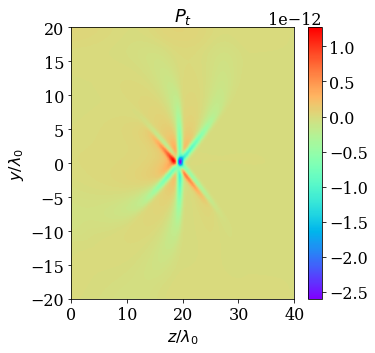

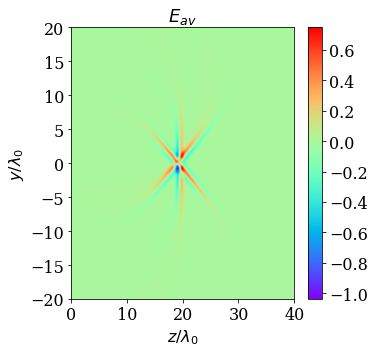

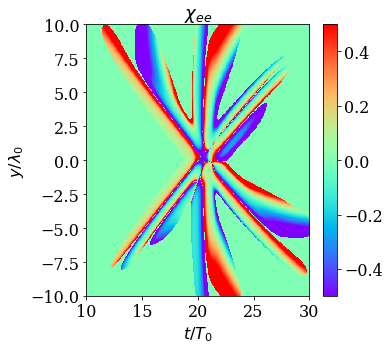

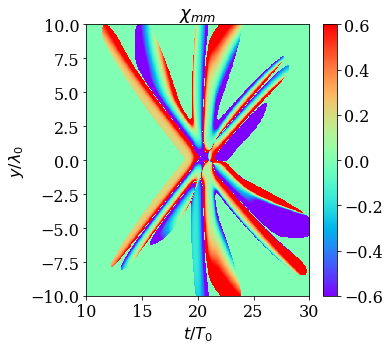

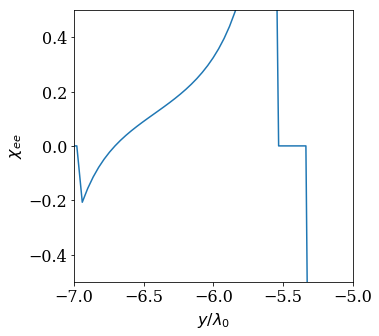

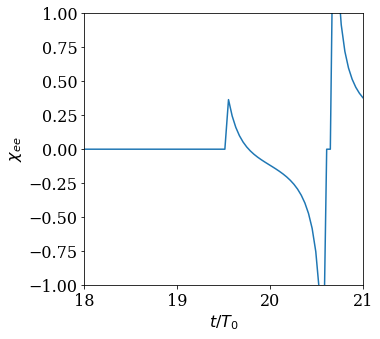

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:108: RuntimeWarning: divide by zero encountered in log10


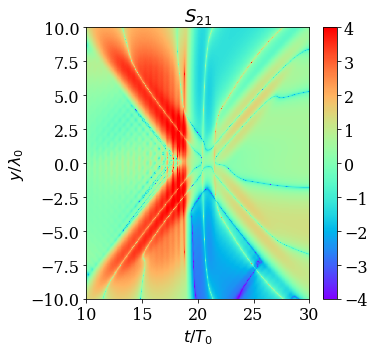

In [32]:
file_ext = '.eps'
figsize(5, 5)
use_imshow = True


IntPt = np.real(Ht_zy_tot_diag - Ht_zy_tot)
IntMt = np.real(Ex_zy_tot_diag - Ex_zy_tot)
Pt = np.zeros(IntPt.shape)
Mt = np.zeros(IntMt.shape)
Pt[Nz-1,:] = IntPt[Nz-1,:]
Mt[Nz-1,:] = IntMt[Nz-1,:]
for i in range(Nz-2, -1, -1):
    Pt[i,:] = Pt[i+1,:] + IntPt[i,:]
    Mt[i,:] = Mt[i+1,:] + IntMt[i,:]

dt = (z[1]-z[0])/constants.c
Pt *= dt
Mt *= dt
    
pcolormesh(Z/L0, Y/L0, Pt, cmap='rainbow')
title(r'$P_t$', fontsize=18)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")
colorbar()
show()

E_av = np.real(Ex_zy_tot + Ex_zy_tot_diag)/2
H_av = np.real(Ht_zy_tot + Ht_zy_tot_diag)/2
pcolormesh(Z/L0, Y/L0, E_av, cmap='rainbow')
title(r'$E_{av}$', fontsize=18)
xlabel(r"$z/\lambda_0$")
ylabel(r"$y/\lambda_0$")
colorbar()
show()

E_max = np.max(np.abs(E_av))
H_max = np.max(np.abs(H_av))
X_ee = np.nan_to_num(Pt/E_av)*(np.abs(E_av)>0.01*E_max)/constants.epsilon_0
X_mm = np.nan_to_num(Mt/H_av)*(np.abs(E_av)>0.01*E_max)/constants.mu_0

flip_z = True
if flip_z:
    X_ee_flipped = np.zeros(X_ee.shape)
    X_mm_flipped = np.zeros(X_mm.shape)
    for i in range(Nz):
        X_ee_flipped[i,:] = X_ee[Nz-1-i,:]
        X_mm_flipped[i,:] = X_mm[Nz-1-i,:]
    X_ee = X_ee_flipped
    X_mm = X_mm_flipped

if use_imshow:
    imshow( X_ee.T, vmin=-0.5, vmax=0.5,\
          cmap='rainbow', interpolation=None,\
          origin='lower', \
          extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
          aspect='auto')
else:
    pcolormesh(Z/L0, Y/L0, X_ee, vmin=-0.1, vmax=0.1, cmap='rainbow')
    
plt.axis([10, 30, -10, 10])
title(r'$\chi_{ee}$', fontsize=18)
xlabel(r"$t/T_0$")
ylabel(r"$y/\lambda_0$")

file_name = os.path.join(dir_name, '{}_X-ee'.format(prefix)+file_ext)
colorbar() 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()


if use_imshow:
    imshow( X_mm.T, vmin=-0.6, vmax=0.6,\
          cmap='rainbow', interpolation=None,\
          origin='lower', \
          extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
          aspect='auto')
else:
    pcolormesh(Z/L0, Y/L0, X_mm, vmin=-0.2, vmax=0.2, cmap='rainbow')
    
plt.axis([10, 30, -10, 10])
title(r'$\chi_{mm}$', fontsize=18)
xlabel(r"$t/T_0$")
ylabel(r"$y/\lambda_0$")

file_name = os.path.join(dir_name, '{}_X-mm'.format(prefix)+file_ext)
colorbar() 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()



plot(y/L0, X_ee[2*Nz//3,:])
ylim([-0.5, 0.5])
xlim([-7, -5])
xlabel(r"$y/\lambda_0$")
ylabel(r'$\chi_{ee}$', fontsize=16)

file_name = os.path.join(dir_name, '{}_X-ee-t-cut'.format(prefix)+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()

plot(z/L0, X_ee[:,2*Ny//3])
ylim([-1.0, 1.0])
xlim([18, 21])
xlabel(r"$t/T_0$")
ylabel(r'$\chi_{ee}$', fontsize=16)

file_name = os.path.join(dir_name, '{}_X-ee-y-cut'.format(prefix)+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=0.1)
show()


####--------------------------------
## S parameters

S_21 = np.log10(np.abs(np.real(Ex_zy_tot_diag)/np.real(Ex_zy_tot)))
#S_21 = S_21*(np.abs(S_21)<=4)
S_21_rev = np.zeros(S_21.shape)
for i in range(Nz):
    S_21_rev[i] = S_21[Nz-1-i]
S_21 = S_21_rev
    
if use_imshow:
    imshow( S_21.T, vmin=-4, vmax=4,\
          cmap='rainbow', interpolation=None,\
          origin='lower', \
          extent=[z[0]/L0, z[-1]/L0, y[0]/L0, y[-1]/L0],\
          aspect='auto')
else:
    pcolormesh(Z/L0, Y/L0, S_21, vmin=None, vmax=None, cmap='rainbow')

plt.axis([10, 30, -10, 10])

title(r'$S_{21}$', fontsize=18)
xlabel(r"$t/T_0$")
ylabel(r"$y/\lambda_0$")
colorbar()
show()



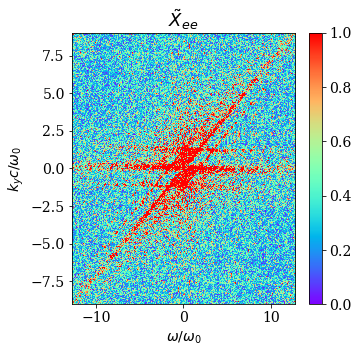

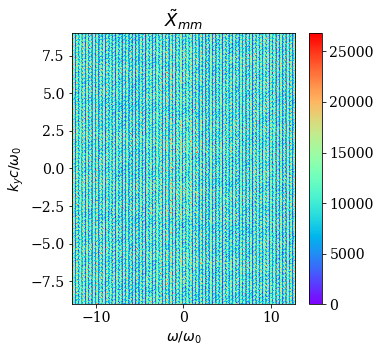

In [24]:
file_ext = '.eps'
figsize(5, 5)
use_imshow = True

X_ee_fft = np.fft.fftshift(np.fft.fft2(np.real(X_ee)))
k_y_arr = FourierReciprocalSpace(y)/np.sqrt(2)
w_t_arr = FourierReciprocalSpace(z/constants.c)
W_t_arr, K_y_arr = np.meshgrid(w_t_arr, k_y_arr, indexing='ij')

if use_imshow:
    imshow( np.abs(X_ee_fft).T/200, vmin=0, vmax=1,\
          cmap='rainbow', interpolation=None,\
          origin='lower', \
          extent=[w_t_arr[0]/(f_c), w_t_arr[-1]/(f_c), k_y_arr[0]*constants.c/(f_c), k_y_arr[-1]*constants.c/(f_c)],\
          aspect='auto')
else:
    pcolormesh(W_t_arr/(f_c), K_y_arr*constants.c/(f_c), np.abs(X_ee_fft)/200, \
           vmin=0, vmax=1, cmap='rainbow')
title(r'$\tilde{X}_{ee}$', fontsize=18)
xlabel(r"$\omega/\omega_0$")
ylabel(r"$k_y c/\omega_0$")

file_name = os.path.join(dir_name, 'gaussian-pulse-X-ee-f'+file_ext)
if chirped:
    file_name = os.path.join(dir_name, 'gaussian-pulse-chirped-X-ee-f'+file_ext)
colorbar() 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)

show()



X_mm_fft = np.fft.fftshift(np.fft.fft2(np.real(X_mm)))
k_y_arr = FourierReciprocalSpace(y)/np.sqrt(2)
w_t_arr = FourierReciprocalSpace(z/constants.c)
W_t_arr, K_y_arr = np.meshgrid(w_t_arr, k_y_arr, indexing='ij')

if use_imshow:
    imshow( np.abs(X_mm_fft).T, vmin=0, vmax=None,\
          cmap='rainbow', interpolation=None,\
          origin='lower', \
          extent=[w_t_arr[0]/(f_c), w_t_arr[-1]/(f_c), k_y_arr[0]*constants.c/(f_c), k_y_arr[-1]*constants.c/(f_c)],\
          aspect='auto')
else:
    pcolormesh(W_t_arr/(f_c), K_y_arr*constants.c/(f_c), np.abs(X_mm_fft)/300, \
           vmin=0, vmax=1, cmap='rainbow')
title(r'$\tilde{X}_{mm}$', fontsize=18)
xlabel(r"$\omega/\omega_0$")
ylabel(r"$k_y c/\omega_0$")

file_name = os.path.join(dir_name, 'gaussian-pulse-X-mm-f'+file_ext)
if chirped:
    file_name = os.path.join(dir_name, 'gaussian-pulse-chirped-X-mm-f'+file_ext)
colorbar() 
savefig(file_name, bbox_inches='tight', pad_inches=0.1)

show()

